# Palladium Price Prediction Using Python & Machine Learning

Taken from source: "https://medium.com/@randerson112358/stock-price-prediction-using-python-machine-learning-e82a039ac2bb"

In [18]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import os
import pandas as pd
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [19]:
os.chdir(r"C:\Users\Mateusz\Desktop\WSBProjekt\data")

In [22]:
# Destination folder 
os.chdir(r"C:\Users\Mateusz\Desktop\WSBProjekt\data")

# Create your connection.
conn = sqlite3.connect('predictions.db')
c = conn.cursor()

# Get SQLLite select statement for Palladium index
df = pd.read_sql_query("SELECT \"Index\",Date FROM Palladium", conn)

# Set index as a date
df.set_index(df['Date'], inplace=True)

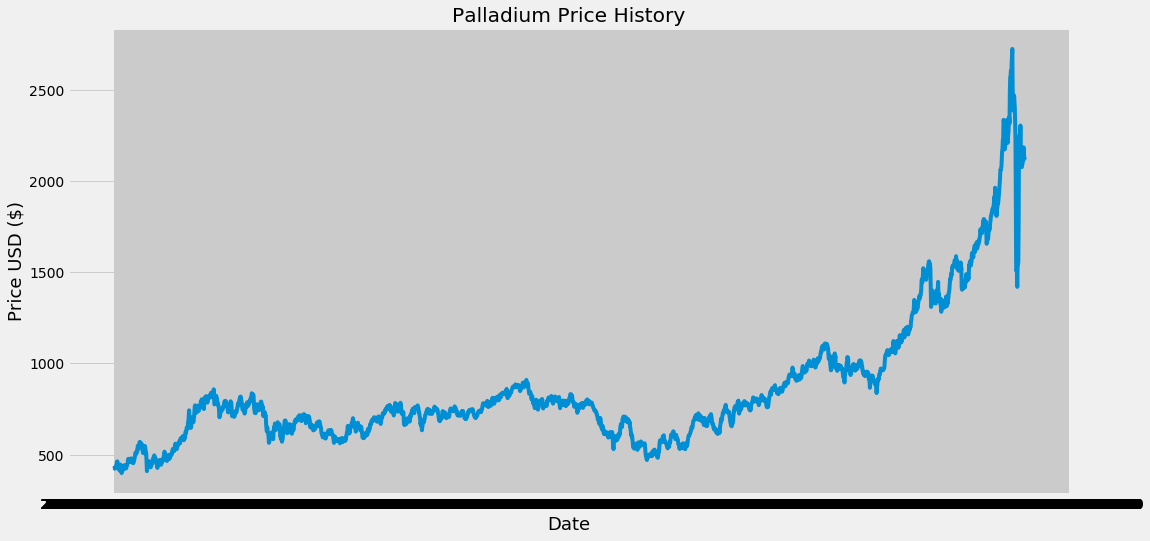

In [30]:
# Simple visualization
plt.figure(figsize=(16,8))
plt.title('Palladium Price History')
plt.plot(df['Index'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)

#Create a new dataframe with only the Index column
data = df.filter(['Index'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.7) 

In [31]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)    
    
  #Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))  

In [26]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
2013/2013 [==============================] - 69s 34ms/step - loss: 2.8211e-04


In [27]:
#We do the same for test data !

#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [28]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\Mateusz\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


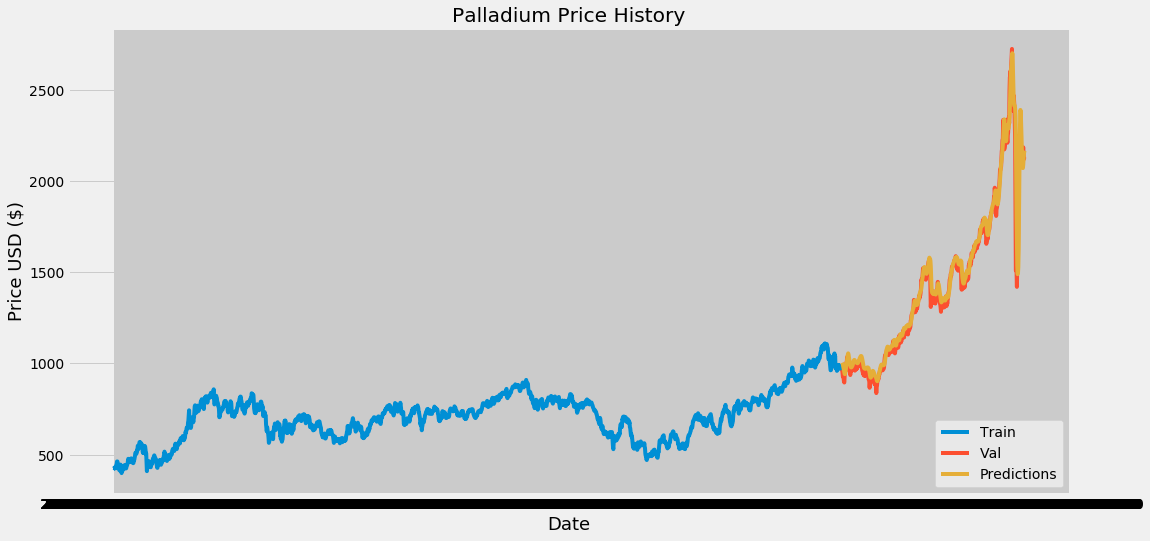

In [29]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Palladium Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(train['Index'])
plt.plot(valid[['Index', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()